In [209]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [210]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [211]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

### Investigate the data, and do any necessary data cleaning.

In [212]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

__Variables that appear to be missing data:__
* lotfrontage 1201/1460 - Linear feet of street connected to property (make NaNs = 0)
* alley 91/1460 - Type of alley access (do we even need this? Let's drop it.)
* masvnrtype, masvnrarea 1452/1460 - Masonry veneer type (make NaNs = "None"); Masonry veneer area in square feet (make NaNs = 0.0)
* bsmtqual, bsmtcond, bsmtfintype1 1423/1460 - Height of the basement; General condition of the basement; Quality of basement finished area (NaN when totalbsmtsf is 0. Fill with "NA")
* bsmtexposure, bsmtfintype2 1422/1460 - Walkout or garden level basement walls; Quality of second finished area (if present) (Mostly NaN when totalbsmtsf is 0. Fill with "NA")
* electrical 1459/1460 - Electrical system (Among other things, 1334 homes have the same value for this, "SBrkr". Let's drop the column--I find it hard to believe this is a predictor of home price.)
* fireplacequ 770/1460 - Fireplace quality (categorical, NaN when Fireplaces = 0. Create new category, "NA")
* garagetype, garageyrblt, garagefinish, garagequal, garagecond 1379/1460 - Garage location; Year garage was built; Interior finish of the garage; Garage quality; Garage condition (NaN when garagearea is 0. Fill with "NA")
* poolqc 7/1460 - Pool quality (poorly populated--drop it.)
* fence 281/1460 - Fence quality (poorly populated--drop it.)
* miscfeature 54/1460 - Miscellaneous feature not covered in other categories (poorly populated and hard to quantify--drop it.)

In [213]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [214]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

In [215]:
house_df.describe().columns

Index(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2',
       'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garagecars', 'garagearea', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold', 'saleprice'],
      dtype='object')

### Explore the data and find some variables that you think would be useful in predicting house prices.

__Here's a quick distribution of the target variable, home sale price:__

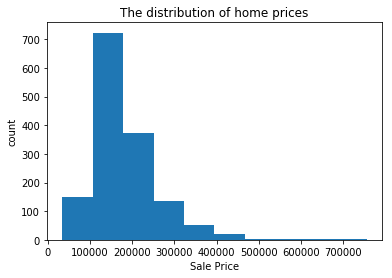

In [216]:
plt.hist(house_df['saleprice'])
plt.title("The distribution of home prices")
plt.xlabel("Sale Price")
plt.ylabel("count")
plt.show()

In [217]:
house_df['saleprice'].describe()

count    1460.000000  
mean     180921.195890
std      79442.502883 
min      34900.000000 
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

In [218]:
house_df.columns

Index(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 'functional',
       'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'wooddecksf', 'openpo

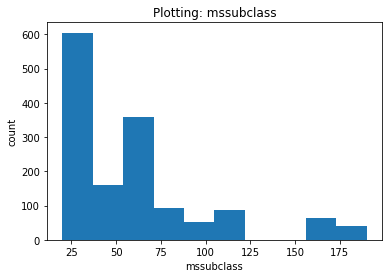

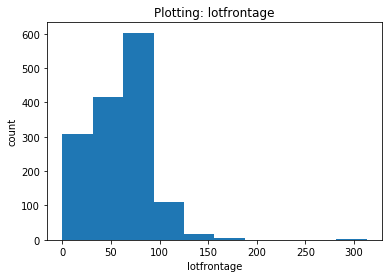

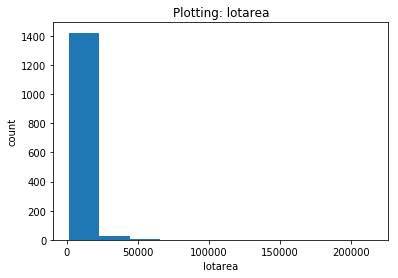

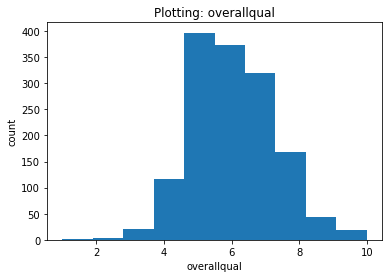

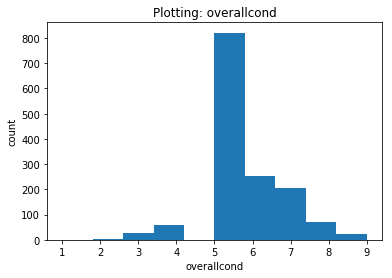

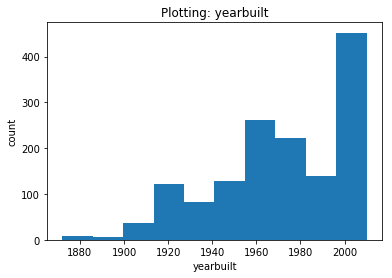

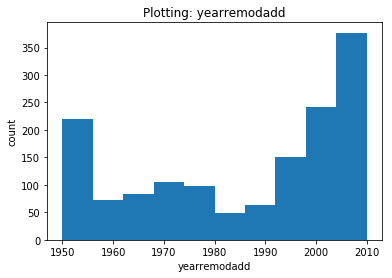

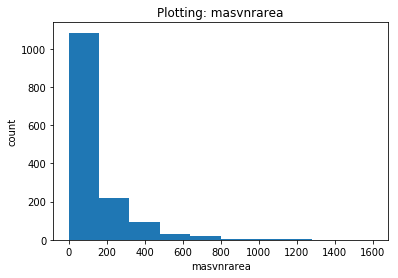

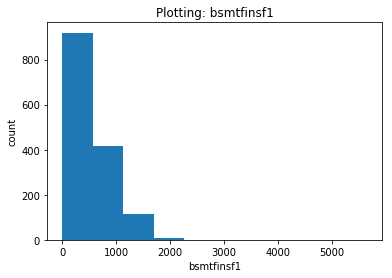

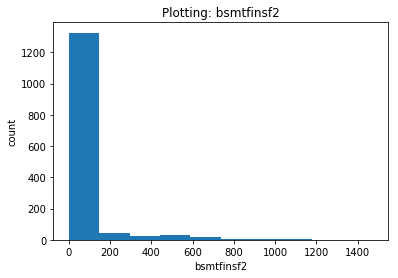

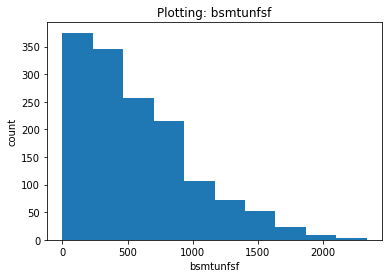

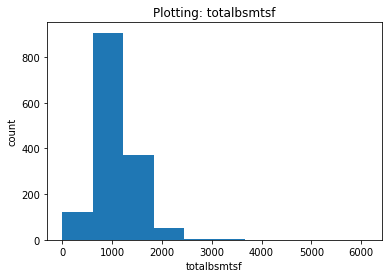

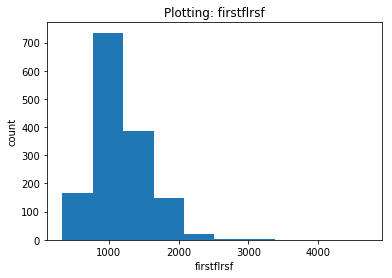

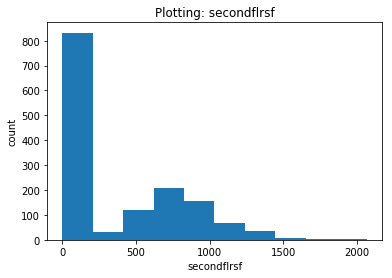

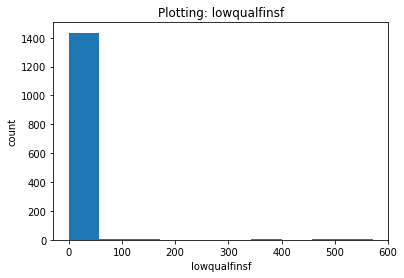

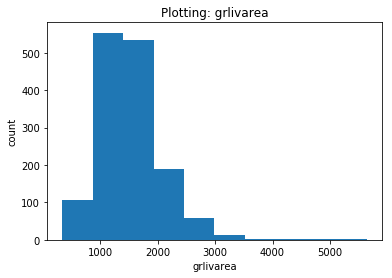

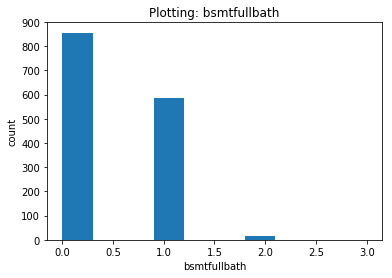

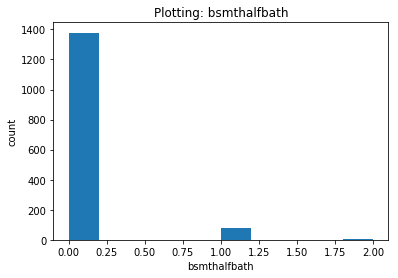

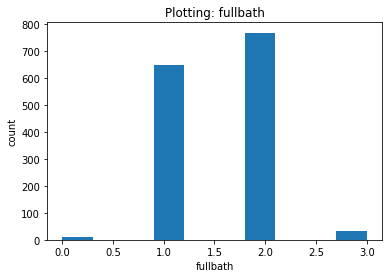

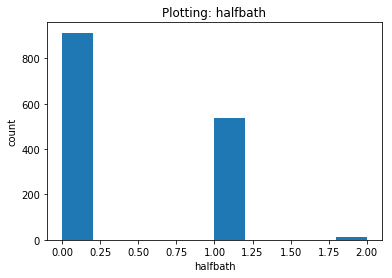

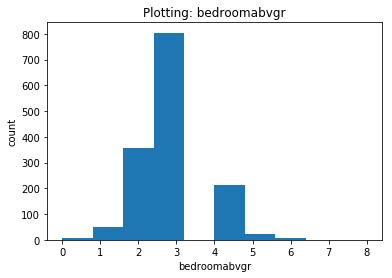

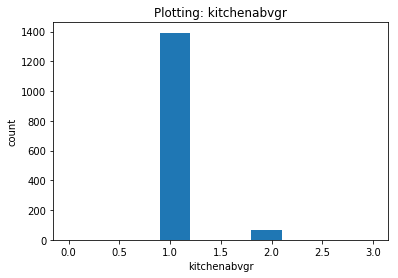

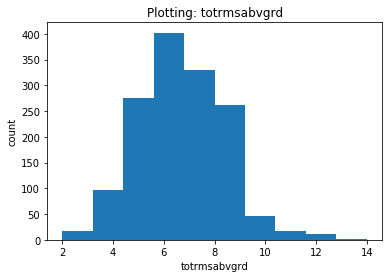

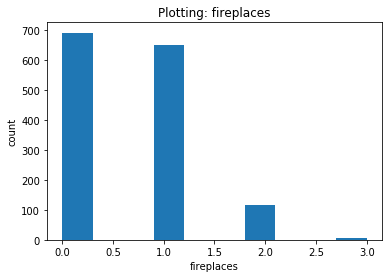

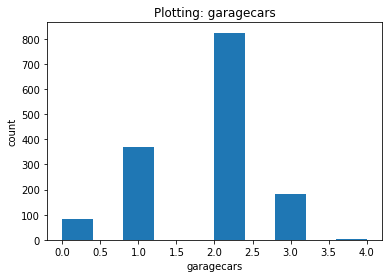

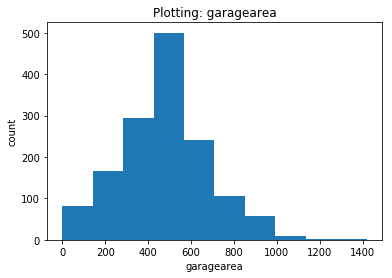

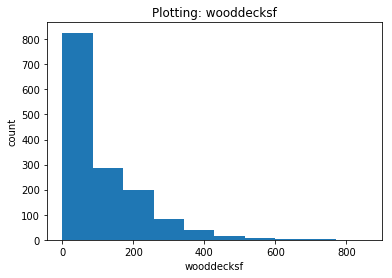

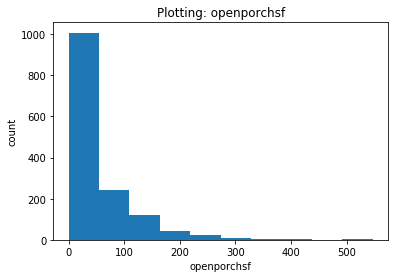

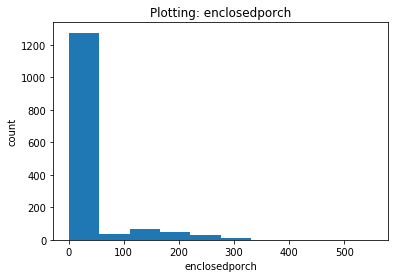

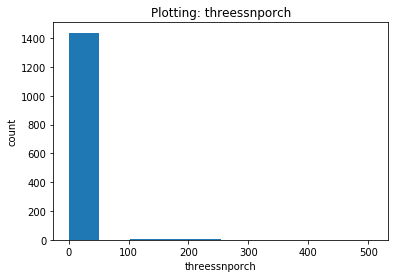

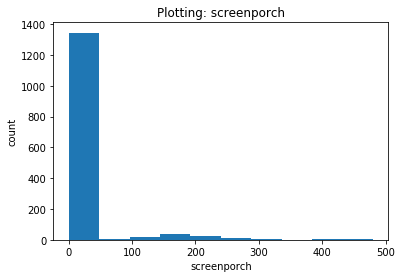

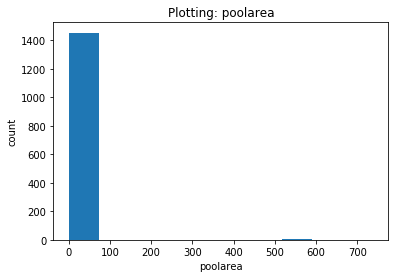

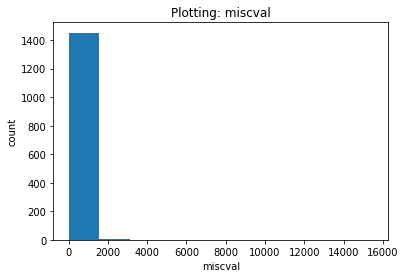

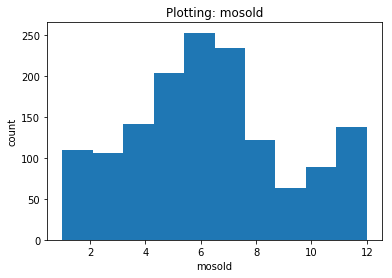

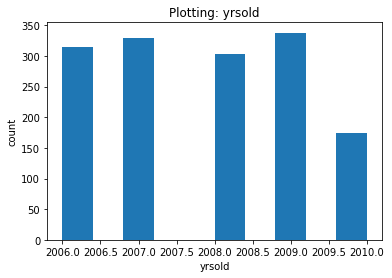

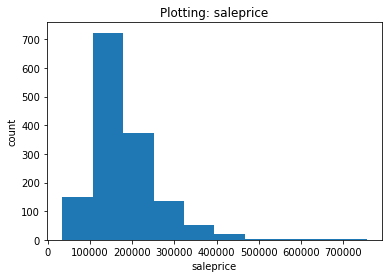

In [219]:
for column in house_df.describe().columns:
    quick_histogram(house_df[column],title="Plotting: {}".format(column),xlabel=column)

__Some guesses at variables that may affect sales price, and a little investigation:__
* LotArea - this variable has what looks like a fairly tight distribution--most lots are under 25,000sq ft 
* Neighborhood - I don't know anything about the neighborhoods of Ames, IA, but I'm betting some of them have higher average sale prices than others.
* BldgType and HouseStyle - The type of building will almost certainly contribute. House style may as well?
* OverallQual, OverallCond - OverallQual rates materials and finish and is almost normally distributed. OverallCond rates overall condition of the property, and is sort of normally distributed--huge peak between 5-6, slightly skewed left. These both seem relevant.
* YearBuilt - Heavily skewed left, but decent distribution. Could be interesting.
* GrLivArea - Above-grade living area, sq ft. Sort of normal distribution, skews right
* FullBath - After reviewing it--meh. Mostly 1s and 2s.
* BedroomAbvGr, TotRmsAbvGrd - Bedrooms/total rooms above ground. Both have a nearly normal distribution.
* Fireplaces - range 0-3, lots of 0s and 1s, very few 2s and 3s.
* GarageCars - Almost normal distribution, range 0-4. Sort of categorical. Area may be better.
* GarageArea - Nearly perfectly normal distribution, skews slightly right.
* PoolArea - Maybe create a new feature from this that indicates whether the house has a pool or not. PoolArea is all < 100 sq ft except for maybe one outlier between 500-600 sq ft.
* MoSold - Does the time of year have an effect on sales price? Could be interesting.
* SaleCondition - I thought this was condition of the property at its time of sale. This looks like a categorical variable describing conditions related to the sale. Not interesting.

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

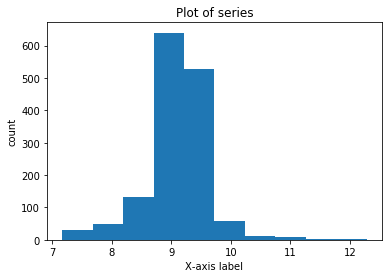

In [220]:
quick_histogram(np.log(house_df['lotarea']))

In [221]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

I think features like a porch and a deck might influence sale price:

In [222]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})

Neighborhood may be able to help predict which prices will be higher. There's certainly a difference in mean sale prices between neighborhoods!

In [223]:
house_df[['neighborhood','saleprice']].groupby('neighborhood').mean().sort_values('saleprice',ascending=False)

,saleprice
neighborhood,
NoRidge,335295.317073
NridgHt,316270.623377
StoneBr,310499.000000
Timber,242247.447368
Veenker,238772.727273
Somerst,225379.837209
ClearCr,212565.428571
Crawfor,210624.725490
CollgCr,197965.773333


In [224]:
# Create a feature describing whether or not the property has a pool
house_df['has_pool'] = (house_df['poolarea'] > 0).map({True: 1, False: 0})
house_df['has_pool'].value_counts()

0    1453
1    7   
Name: has_pool, dtype: int64

Okay honestly, there are only 7 pools, so this is probably not going to be much of a contributing factor. But we can at least look at the sale prices of these 7 properties and see where their sale prices are in the overall range.

In [225]:
house_df.loc[house_df['has_pool'] == True,['has_pool','saleprice']]

,has_pool,saleprice
198,1,235000
810,1,181000
1170,1,171000
1182,1,745000
1298,1,160000
1386,1,250000
1423,1,274970


This doesn't look very conclusive to me. Let's skip this after all.

### Multivariate analysis

In [226]:
# Interesting variables we can try plotting against sale price
vars_of_interest = ['saleprice','log_lotarea','neighborhood','bldgtype','housestyle','yearbuilt',
                    'grlivarea','garagearea','has_deck','has_porch','mosold']

In [227]:
house_interest_df = house_df[vars_of_interest]
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,grlivarea,garagearea,has_deck,has_porch,mosold
0,208500,9.041922,CollgCr,1Fam,2Story,2003,1710,548,0,1,2
1,181500,9.169518,Veenker,1Fam,1Story,1976,1262,460,1,0,5
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1786,608,0,1,9
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1717,642,0,1,2
4,250000,9.565214,NoRidge,1Fam,2Story,2000,2198,836,1,1,12


In [228]:
house_corr = house_interest_df.corr()

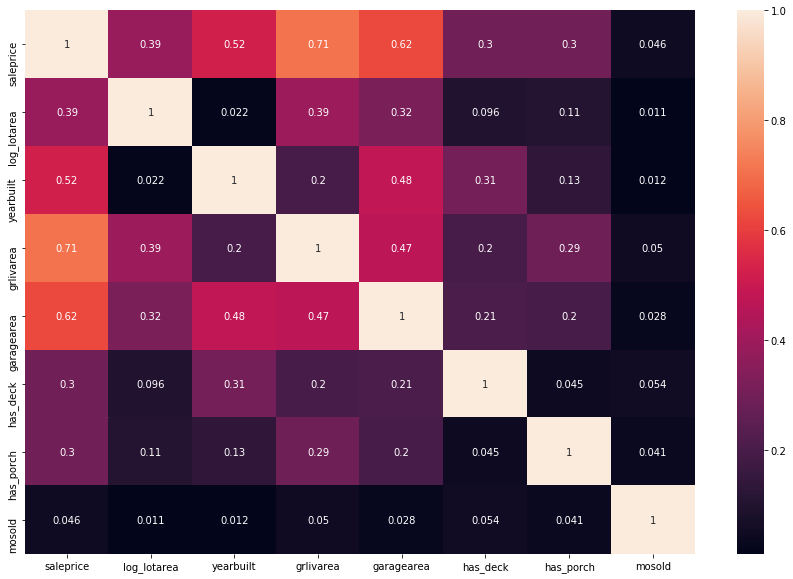

In [229]:
# We can also check out a heatmap to see the correlation between our target and our continuous variables
plt.figure(figsize=(15,10))
sns.heatmap(house_corr, annot=True)


In [230]:
house_corr.loc['saleprice'].sort_values(ascending=False)

saleprice      1.000000
grlivarea      0.708624
garagearea     0.623431
yearbuilt      0.522897
log_lotarea    0.388520
has_deck       0.297662
has_porch      0.296678
mosold         0.046432
Name: saleprice, dtype: float64

Let's look more closely at neighborhoods too.

In [231]:
hot_neighborhood_df = pd.get_dummies(house_df['neighborhood'],drop_first=True)
hot_neighborhood_df['saleprice'] = house_df['saleprice']
hot_neighborhood_df.head()

,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,saleprice
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208500
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,181500
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,223500
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,140000
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,250000


In [232]:
hot_neighborhood_corr = hot_neighborhood_df.corr()

The heat map for this one is crowded, but we can look at the relevant column and sort its values to see which neighborhoods have the strongest correlation with a higher sale price:

In [233]:
hot_neighborhood_corr.loc['saleprice'].sort_values(ascending=False)

saleprice    1.000000
NridgHt      0.402149
NoRidge      0.330424
StoneBr      0.215363
Somerst      0.140058
Timber       0.126236
CollgCr      0.072626
Crawfor      0.071160
Veenker      0.063471
ClearCr      0.055718
Gilbert      0.035940
NWAmes       0.023483
SawyerW      0.014560
Blueste     -0.020250
NPkVill     -0.037910
Mitchel     -0.057845
SWISU       -0.063705
BrDale      -0.101303
MeadowV     -0.112544
Sawyer      -0.128394
BrkSide     -0.143648
IDOTRR      -0.164056
Edwards     -0.179949
NAmes       -0.188513
OldTown     -0.192189
Name: saleprice, dtype: float64

Are the relationships for the most correlated neighborhoods strong enough to bother? I guess we can find out...

__The neighborhoods with the strongest correlation to higher sale prices are:__
* NridgHt
* NoRidge
* StoneBr
* Somerst
* Timber

__How about the type of building or house style?__

In [234]:
hot_housetype_df = pd.get_dummies(house_df['bldgtype'],drop_first=True)
hot_housetype_df = pd.concat([hot_housetype_df, pd.get_dummies(house_df['housestyle'],drop_first=True)], axis=1)
hot_housetype_df['saleprice'] = house_df['saleprice']

In [235]:
hot_housetype_corr = hot_housetype_df.corr()
hot_housetype_corr['saleprice'].sort_values(ascending=False)

saleprice    1.000000
2Story       0.242880
2.5Fin       0.036526
TwnhsE       0.003804
2.5Unf      -0.025856
SLvl        -0.038645
1Story      -0.061811
1.5Unf      -0.087686
SFoyer      -0.093090
2fmCon      -0.097348
Twnhs       -0.098730
Duplex      -0.114655
Name: saleprice, dtype: float64

A 2-story house has at least some kind of correlation with higher sale price.

In [236]:
pd.get_dummies(house_df['housestyle'])['2Story'].value_counts()

0    1015
1    445 
Name: 2Story, dtype: int64

And we see 2-story houses often enough for this to feel relevant? Let's include that variable, at least.

In [237]:
# Append one-hot versions of neighborhoods and house style to the dataframe of interesting variables
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['neighborhood'],drop_first=True)], axis=1)
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['housestyle'],drop_first=True)], axis=1)
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,grlivarea,garagearea,has_deck,has_porch,mosold,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,208500,9.041922,CollgCr,1Fam,2Story,2003,1710,548,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,181500,9.169518,Veenker,1Fam,1Story,1976,1262,460,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1786,608,0,1,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1717,642,0,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,250000,9.565214,NoRidge,1Fam,2Story,2000,2198,836,1,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Build your initial model using these features and estimate the parameters using OLS.

In [238]:
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_deck','has_porch','mosold',
                  'Blueste','BrDale','BrkSide','ClearCr','CollgCr','Crawfor','Edwards','Gilbert','IDOTRR',
                  'MeadowV','Mitchel','NAmes','NPkVill','NWAmes','NoRidge','NridgHt','OldTown','SWISU','Sawyer',
                  'SawyerW','Somerst','StoneBr','Timber','Veenker','1.5Unf','1Story','2.5Fin','2.5Unf','2Story',
                  'SFoyer','SLvl']

In [239]:
# Y is the target variable
Y = house_interest_df['saleprice']
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 2.27004395e+04  5.99549356e+02  7.43955085e+01  3.29106635e+01
  7.64887177e+03  7.94999198e+03 -3.49721818e+02  6.67812017e+03
  3.08819969e+03 -2.78516390e+03 -1.25105975e+04 -9.99103633e+03
  2.25503133e+04 -3.45916828e+04 -1.92975416e+04 -2.33300554e+04
 -1.91766858e+04 -3.16488826e+04 -2.36564210e+04  6.90129846e+02
 -2.51095597e+04  4.72639964e+04  6.08559983e+04 -1.72046756e+04
 -2.05177536e+04 -2.91227245e+04 -2.22704464e+04  1.37599784e+04
  6.87430920e+04  2.77031752e+03  2.13877747e+04  2.33890914e+04
  1.56925412e+04 -1.60914932e+04 -1.77587348e+03 -5.34651714e+03
  2.62992287e+04  1.29477820e+04]

Intercept: 
 -1342492.7705383622


In [240]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     143.2
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               0.00
Time:                        23:03:11   Log-Likelihood:                -17395.
No. Observations:                1460   AIC:                         3.487e+04
Df Residuals:                    1421   BIC:                         3.507e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.342e+06   1.52e+05     -8.806      0.000   -1.64e+06   -1.04e+06
log_lotarea   2.27e+04   2894.991      7.841      0.000     1.7e+04    2.84e+04
yearbuilt     599.5494     73.493      8.158      0.000     455.384     743.715
grlivarea      74.3955      3.113     23.896      0.000      68.288      80.503
garagearea     32.9107      6.288      5.233      0.000      20.575      45.246
has_deck     7648.8718   2107.224      3.630      0.000    3515.269    1.18e+04
has_porch    7949.9920   2265.244      3.510      0.000    3506.411    1.24e+04
mosold       -349.7218    359.179     -0.974      0.330   -1054.301     354.857
Blueste      6678.1202   2.77e+04      0.241      0.810   -4.77e+04     6.1e+04
BrDale       3088.1997   1.35e+04      0.229      0.819   -2.33e+04    2.95e+04
BrkSide     -2785.1639   1.16e+04     -0.241      0.810   -2.55e+04    1.99e+04
ClearCr     -1.251e+04   1.25e+04     -1.000      0.317    -3.7e+04     1.2e+04
CollgCr     -9991.0363   9944.858     -1.005      0.315   -2.95e+04    9517.144
Crawfor      2.255e+04   1.16e+04      1.952      0.051    -110.083    4.52e+04
Edwards     -3.459e+04   1.06e+04     -3.256      0.001   -5.54e+04   -1.38e+04
Gilbert      -1.93e+04   1.07e+04     -1.805      0.071   -4.03e+04    1669.504
IDOTRR      -2.333e+04   1.23e+04     -1.901      0.058   -4.74e+04     747.087
MeadowV     -1.918e+04   1.32e+04     -1.455      0.146    -4.5e+04    6685.723
Mitchel     -3.165e+04    1.1e+04     -2.869      0.004   -5.33e+04      -1e+04
NAmes       -2.366e+04   1.02e+04     -2.312      0.021   -4.37e+04   -3585.266
NPkVill       690.1298   1.54e+04      0.045      0.964   -2.95e+04    3.08e+04
NWAmes      -2.511e+04   1.07e+04     -2.352      0.019   -4.61e+04   -4166.772
NoRidge      4.726e+04   1.13e+04      4.172      0.000     2.5e+04    6.95e+04
NridgHt      6.086e+04   1.03e+04      5.905      0.000    4.06e+04    8.11e+04
OldTown      -1.72e+04   1.13e+04     -1.526      0.127   -3.93e+04    4916.007
SWISU       -2.052e+04   1.31e+04     -1.567      0.117   -4.62e+04    5170.851
Sawyer      -2.912e+04   1.08e+04     -2.697      0.007   -5.03e+04   -7940.984
SawyerW     -2.227e+04   1.07e+04     -2.087      0.037   -4.32e+04   -1342.631
Somerst      1.376e+04   1.02e+04      1.351      0.177   -6213.396    3.37e+04
StoneBr      6.874e+04   1.18e+04      5.819      0.000    4.56e+04    9.19e+04
Timber       2770.3175   1.15e+04      0.241      0.810   -1.98e+04    2.53e+04
Veenker      2.139e+04   1.48e+04      1.448      0.148   -7588.112    5.04e+04
1.5Unf       2.339e+04   1.05e+04      2.228      0.026    2800.636     4.4e+04
1Story       1.569e+04   3930.709      3.992      0.000    7981.926    2.34e+04
2.5Fin      -1.609e+04   1.42e+04     -1.130      0.259    -4.4e+04    1.18e+04
2.5Unf      -1775.8735   1.17e+04     -0.15

The high P values on a lot of the neighborhood-related features make me think they can be dropped. Let's clean up house_interest_df and try again.

In [246]:
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_deck','has_porch',
                  'Crawfor','Edwards','Gilbert','IDOTRR',
                  'Mitchel','NAmes','NWAmes','NoRidge','NridgHt','Sawyer',
                  'SawyerW','StoneBr','1.5Unf','1Story',
                  'SFoyer','SLvl']

In [247]:
# Y is the target variable
Y = house_interest_df['saleprice']
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 2.25992104e+04  7.24314466e+02  7.24716625e+01  3.64921305e+01
  6.63760528e+03  8.02604624e+03  3.19102650e+04 -2.57695319e+04
 -1.80716591e+04 -1.15111825e+04 -2.65136066e+04 -1.64891134e+04
 -2.01885382e+04  4.97903641e+04  6.17023109e+04 -2.17564232e+04
 -1.89643526e+04  7.07726339e+04  2.89152179e+04  1.83035076e+04
  2.41249298e+04  1.57862388e+04]

Intercept: 
 -1596896.6207619624


In [248]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     240.4
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               0.00
Time:                        23:05:03   Log-Likelihood:                -17417.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1437   BIC:                         3.500e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.597e+06   9.11e+04    -17.532      0.000   -1.78e+06   -1.42e+06
log_lotarea   2.26e+04   2310.218      9.782      0.000    1.81e+04    2.71e+04
yearbuilt     724.3145     44.015     16.456      0.000     637.974     810.655
grlivarea      72.4717      2.981     24.313      0.000      66.624      78.319
garagearea     36.4921      6.212      5.874      0.000      24.306      48.678
has_deck     6637.6053   2093.551      3.171      0.002    2530.861    1.07e+04
has_porch    8026.0462   2247.099      3.572      0.000    3618.100    1.24e+04
Crawfor      3.191e+04   5610.448      5.688      0.000    2.09e+04    4.29e+04
Edwards     -2.577e+04   4170.594     -6.179      0.000    -3.4e+04   -1.76e+04
Gilbert     -1.807e+04   4818.267     -3.751      0.000   -2.75e+04   -8620.069
IDOTRR      -1.151e+04   6535.844     -1.761      0.078   -2.43e+04    1309.636
Mitchel     -2.651e+04   5669.995     -4.676      0.000   -3.76e+04   -1.54e+04
NAmes       -1.649e+04   3154.675     -5.227      0.000   -2.27e+04   -1.03e+04
NWAmes      -2.019e+04   4714.807     -4.282      0.000   -2.94e+04   -1.09e+04
NoRidge      4.979e+04   6422.082      7.753      0.000    3.72e+04    6.24e+04
NridgHt       6.17e+04   4840.362     12.747      0.000    5.22e+04    7.12e+04
Sawyer      -2.176e+04   4772.362     -4.559      0.000   -3.11e+04   -1.24e+04
SawyerW     -1.896e+04   5149.110     -3.683      0.000   -2.91e+04   -8863.775
StoneBr      7.077e+04   7730.303      9.155      0.000    5.56e+04    8.59e+04
1.5Unf       2.892e+04   1.03e+04      2.814      0.005    8756.055    4.91e+04
1Story        1.83e+04   2717.377      6.736      0.000     1.3e+04    2.36e+04
SFoyer       2.412e+04   6776.886      3.560      0.000    1.08e+04    3.74e+04
SLvl         1.579e+04   5169.530      3.054      0.002    5645.604    2.59e+04
==============================================================================
Omnibus:                      363.432   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20463.145
Skew:                           0.134   Prob(JB):                         0.00
Kurtosis:                      21.339   Cond. No.                     2.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### That doesn't look bad, right?

The R-squared value suggests our model can explain 78.3% of the data. The adjusted R-squared value is nearly the same, so we aren't being penalized for redundant features. 

The F-statistic is a lot higher than the first run.

The p-values of the features are all close to zero (still kind of eyeing IDOTRR, wondering if I should dump it too...?).